   Unnamed: 0    state  Year  cost_per_pack  sales_per_capita  tax_dollar  \
0           0  Alabama  1970          0.427              89.8         0.2   
1           1  Alabama  1971          0.423              95.4         0.2   
2           2  Alabama  1972          0.421             101.1         0.2   
3           3  Alabama  1973          0.431             102.9         0.2   
4           4  Alabama  1974          0.466             108.2         0.2   

   tax_percent  tax_revenue  tax_state      index  price_cpi  tax_2012  
0         46.8   36739131.0       0.12  38.825000   2.529556  0.710882  
1         47.3   39490694.0       0.12  40.491667   2.402717  0.681622  
2         47.5   42198422.0       0.12  41.816667   2.315584  0.660024  
3         46.4   43328876.0       0.12  44.400000   2.232658  0.621622  
4         42.9   45943402.0       0.12  49.308333   2.173669  0.559743  


/var/folders/mn/l2nrwsxn24g6ywz6ygh2fxp40000gn/T/ipykernel_12950/1920921652.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataq1['tax_change'] = dataq1.groupby('state')['tax_state'].diff().ne(0).astype(int)


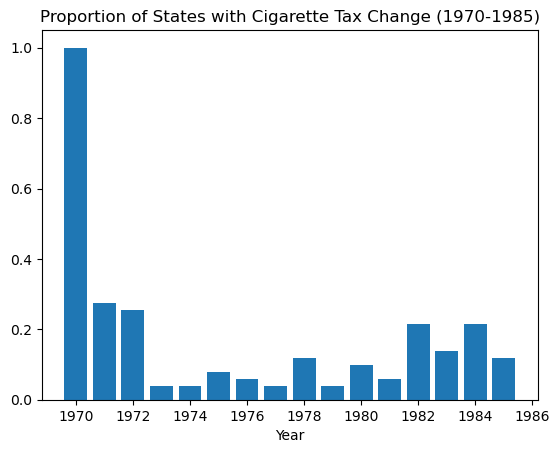

In [25]:
#summarize data
#import data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm


#load data
data = pd.read_csv('/Users/ryanscholte/Desktop/GitHub/HW3/data/output/tax_data.csv')
#show head
print(data.head())

#Present a bar graph showing the proportion of states with a change in their cigarette tax in each year.
data = data.sort_values(by=['state', 'Year'])
#limit data year between 1970 and 1985
dataq1=data[(data['Year']>=1970) & (data['Year']<=1985)]
dataq1['tax_change'] = dataq1.groupby('state')['tax_state'].diff().ne(0).astype(int)
tax_change_proportion = dataq1.groupby('Year')['tax_change'].mean()
# print(tax_change_proportion)
plt.bar(tax_change_proportion.index, tax_change_proportion.values)
plt.title('Proportion of States with Cigarette Tax Change (1970-1985)')
plt.xlabel('Year')
plt.show()
#check if all values in each state and each year are the same or not for the tax percent column



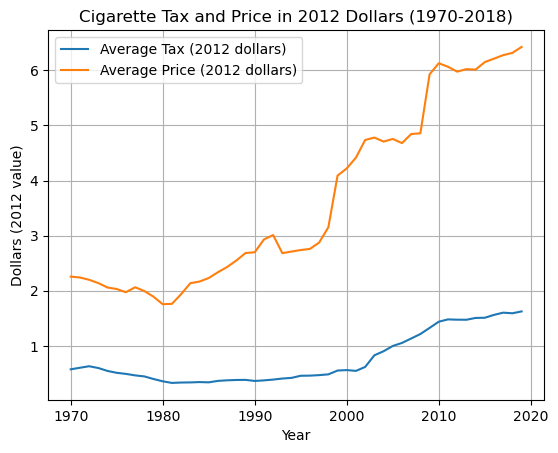

In [26]:
avg_values = data.groupby('Year')[['tax_2012', 'price_cpi']].mean()


#line graph
plt.plot(avg_values.index, avg_values['tax_2012'], label='Average Tax (2012 dollars)')
plt.plot(avg_values.index, avg_values['price_cpi'], label='Average Price (2012 dollars)')
plt.legend()
plt.title('Cigarette Tax and Price in 2012 Dollars (1970-2018)')
plt.xlabel('Year')
plt.ylabel('Dollars (2012 value)')
plt.grid(True)
plt.show()



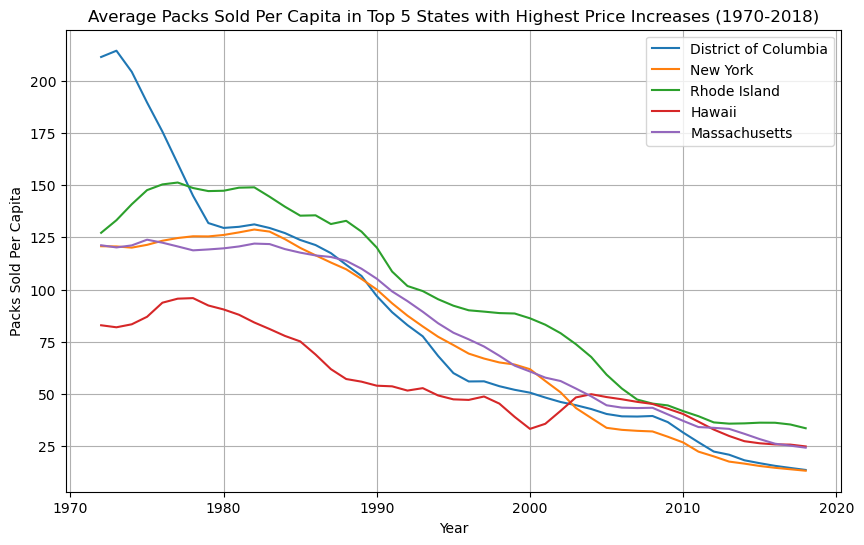

In [27]:
# Filter for years 1970-2018
dataq3 = data[(data['Year'] >= 1970) & (data['Year'] <= 2018)]

# Compute the price difference between 1970 and 2018
price_change = dataq3.groupby('state')['price_cpi'].agg(['first', 'last'])
price_change['price_increase'] = price_change['last'] - price_change['first']

#top 5 states with the highest price increase
big_5_states = price_change.nlargest(5, 'price_increase').index.tolist()
big_5_data = dataq3[dataq3['state'].isin(big_5_states)]

plt.figure(figsize=(10, 6))
for state in big_5_states:
    state_data = big_5_data[big_5_data['state'] == state]
    plt.plot(state_data['Year'], state_data['sales_per_capita'].rolling(window=3).mean(), label=state)

plt.title('Average Packs Sold Per Capita in Top 5 States with Highest Price Increases (1970-2018)')
plt.xlabel('Year')
plt.ylabel('Packs Sold Per Capita')
plt.legend()
plt.grid(True)

plt.show()

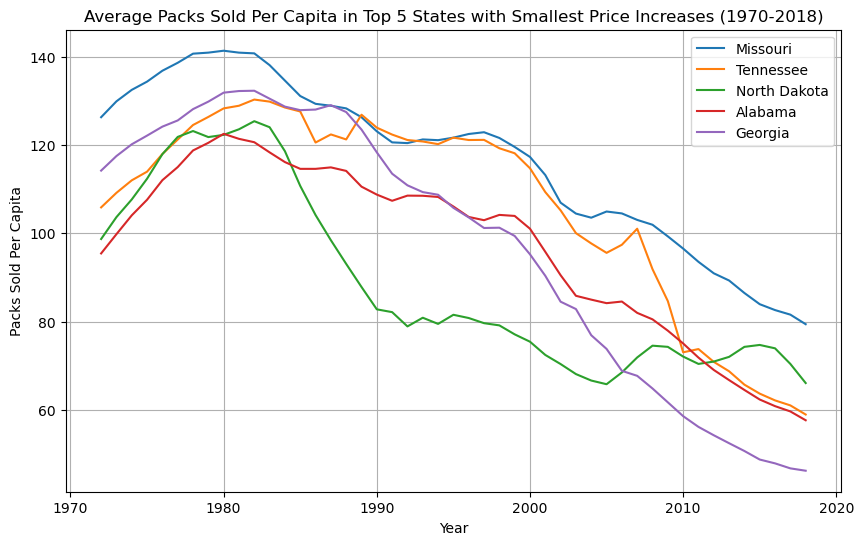

In [28]:
small_5_states = price_change.nsmallest(5, 'price_increase').index.tolist()
small_5_data = dataq3[dataq3['state'].isin(small_5_states)]

plt.figure(figsize=(10, 6))
for state in small_5_states:
    state_data = small_5_data[small_5_data['state'] == state]
    plt.plot(state_data['Year'], state_data['sales_per_capita'].rolling(window=3).mean(), label=state)

plt.title('Average Packs Sold Per Capita in Top 5 States with Smallest Price Increases (1970-2018)')
plt.xlabel('Year')
plt.ylabel('Packs Sold Per Capita')
plt.legend()
plt.grid(True)
plt.show()

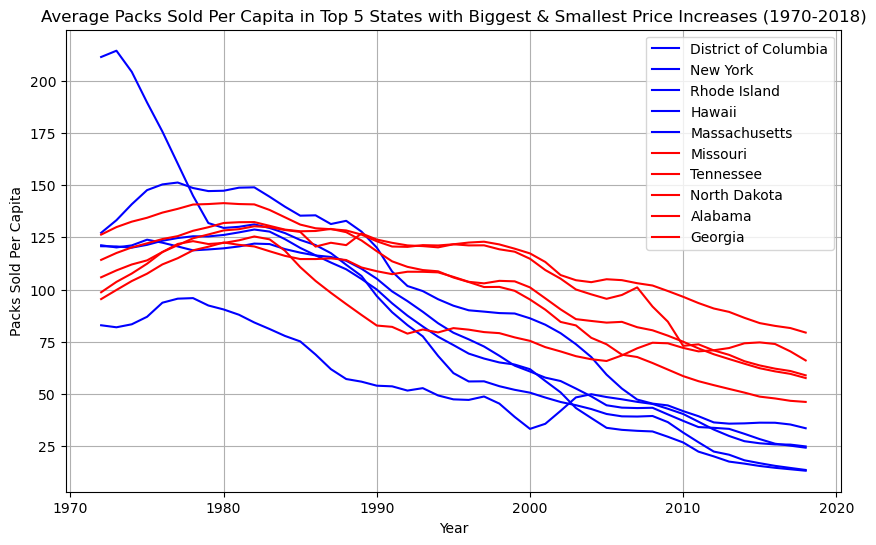

In [29]:
#overlay the two graphs and make all lines of one graph the same color
plt.figure(figsize=(10, 6))
for state in big_5_states:
    state_data = big_5_data[big_5_data['state'] == state]
    plt.plot(state_data['Year'], state_data['sales_per_capita'].rolling(window=3).mean(), label=state, color='blue')
for state in small_5_states:
    state_data = small_5_data[small_5_data['state'] == state]
    plt.plot(state_data['Year'], state_data['sales_per_capita'].rolling(window=3).mean(), label=state, color='red')
plt.title('Average Packs Sold Per Capita in Top 5 States with Biggest & Smallest Price Increases (1970-2018)')
plt.xlabel('Year')
plt.ylabel('Packs Sold Per Capita')
plt.legend()
plt.grid(True)
plt.show()

Both start with similar sales per capita, but the states with the highest price increases have a steeper decline in sales per capita compared to the states with the smallest price increases. You can see this as they all end with a lower number of packs sold per capita than all the red(low price increase) states. This suggests that significant price increases do decrease cigarette sales per capita further. 

In [30]:
#estimate ATE's for 1970 to 1990

cig_data = data[(data['Year'] >= 1970) & (data['Year'] <= 1990)]

cig_data['ln_sales'] = np.log(cig_data['sales_per_capita'])
cig_data['ln_price'] = np.log(cig_data['cost_per_pack'])
cig_data['ln_total_tax'] = np.log(cig_data['tax_dollar'])


#  OLS 
X = sm.add_constant(cig_data['ln_price'])  # Add constant for intercept
y = cig_data['ln_sales']

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               ln_sales   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.125
Method:                 Least Squares   F-statistic:                     153.9
Date:                Mon, 17 Mar 2025   Prob (F-statistic):           4.18e-33
Time:                        09:46:03   Log-Likelihood:                 148.99
No. Observations:                1071   AIC:                            -294.0
Df Residuals:                    1069   BIC:                            -284.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.7504      0.008    585.321      0.0

/var/folders/mn/l2nrwsxn24g6ywz6ygh2fxp40000gn/T/ipykernel_12950/125810306.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cig_data['ln_sales'] = np.log(cig_data['sales_per_capita'])
/var/folders/mn/l2nrwsxn24g6ywz6ygh2fxp40000gn/T/ipykernel_12950/125810306.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cig_data['ln_price'] = np.log(cig_data['cost_per_pack'])
/var/folders/mn/l2nrwsxn24g6ywz6ygh2fxp40000gn/T/ipykernel_12950/125810306.py:7: SettingWithCopyWarning: 
A value is trying to be set on a co

In [31]:
# First stage
step1 = sm.OLS(cig_data['ln_price'], sm.add_constant(cig_data['ln_total_tax'])).fit()
print("First-stage Regression (ln_price ~ ln_total_tax):\n")
print(step1.summary())

First-stage Regression (ln_price ~ ln_total_tax):

                            OLS Regression Results                            
Dep. Variable:               ln_price   R-squared:                       0.683
Model:                            OLS   Adj. R-squared:                  0.683
Method:                 Least Squares   F-statistic:                     2301.
Date:                Mon, 17 Mar 2025   Prob (F-statistic):          8.21e-269
Time:                        09:46:04   Log-Likelihood:                -86.164
No. Observations:                1071   AIC:                             176.3
Df Residuals:                    1069   BIC:                             186.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

In [32]:
# Log prices from the first stage
pricehat = step1.predict(sm.add_constant(cig_data['ln_total_tax']))

# Second-stage regression (IV Regression)
step2 = sm.OLS(cig_data['ln_sales'], sm.add_constant(pricehat)).fit()
print("\nSecond-stage Regression (ln_sales ~ pricehat):\n")
print(step2.summary())


Second-stage Regression (ln_sales ~ pricehat):

                            OLS Regression Results                            
Dep. Variable:               ln_sales   R-squared:                       0.236
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     330.3
Date:                Mon, 17 Mar 2025   Prob (F-statistic):           1.56e-64
Time:                        09:46:04   Log-Likelihood:                 221.17
No. Observations:                1071   AIC:                            -438.3
Df Residuals:                    1069   BIC:                            -428.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
con

the value of OLS without the instrument is -0.17 and with the instrument is -0.28.  This means that a 1% increase in price will decrease sales per capita by 0.17% or 0.28%. They are different and this is due the the endogeneity in the naive estimate. For example a state could increase the tax rate because it has a high smoking rate, and this would bias the estimate.

In [33]:
#estimate ATE's for 1991 to 2015
import statsmodels.api as sm

cig_data2 = data[(data['Year'] >= 1991) & (data['Year'] <= 2015)]

cig_data2['ln_sales'] = np.log(cig_data2['sales_per_capita'])
cig_data2['ln_price'] = np.log(cig_data2['cost_per_pack'])
cig_data2['ln_total_tax'] = np.log(cig_data2['tax_dollar'])


#  OLS 
X2 = sm.add_constant(cig_data2['ln_price'])  
Y2 = cig_data2['ln_sales']

model2 = sm.OLS(Y2, X2).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:               ln_sales   R-squared:                       0.533
Model:                            OLS   Adj. R-squared:                  0.532
Method:                 Least Squares   F-statistic:                     1451.
Date:                Mon, 17 Mar 2025   Prob (F-statistic):          1.52e-212
Time:                        09:46:04   Log-Likelihood:                -296.47
No. Observations:                1275   AIC:                             596.9
Df Residuals:                    1273   BIC:                             607.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0395      0.023    219.934      0.0

/var/folders/mn/l2nrwsxn24g6ywz6ygh2fxp40000gn/T/ipykernel_12950/3516104511.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cig_data2['ln_sales'] = np.log(cig_data2['sales_per_capita'])
/var/folders/mn/l2nrwsxn24g6ywz6ygh2fxp40000gn/T/ipykernel_12950/3516104511.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cig_data2['ln_price'] = np.log(cig_data2['cost_per_pack'])
/var/folders/mn/l2nrwsxn24g6ywz6ygh2fxp40000gn/T/ipykernel_12950/3516104511.py:8: SettingWithCopyWarning: 
A value is trying to be set 

In [34]:
# First stage
step1_2 = sm.OLS(cig_data2['ln_price'], sm.add_constant(cig_data2['ln_total_tax'])).fit()
print("First-stage Regression (ln_price ~ ln_total_tax):\n")
print(step1_2.summary())

First-stage Regression (ln_price ~ ln_total_tax):

                            OLS Regression Results                            
Dep. Variable:               ln_price   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     8442.
Date:                Mon, 17 Mar 2025   Prob (F-statistic):               0.00
Time:                        09:46:04   Log-Likelihood:                 396.65
No. Observations:                1275   AIC:                            -789.3
Df Residuals:                    1273   BIC:                            -779.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

In [35]:
# Log prices from the first stage
pricehat_2 = step1_2.predict(sm.add_constant(cig_data2['ln_total_tax']))

# Second stage
step2_2 = sm.OLS(cig_data2['ln_sales'], sm.add_constant(pricehat_2)).fit()
print("\nSecond-stage Regression (ln_sales ~ pricehat):\n")
print(step2_2.summary())


Second-stage Regression (ln_sales ~ pricehat):

                            OLS Regression Results                            
Dep. Variable:               ln_sales   R-squared:                       0.608
Model:                            OLS   Adj. R-squared:                  0.607
Method:                 Least Squares   F-statistic:                     1972.
Date:                Mon, 17 Mar 2025   Prob (F-statistic):          6.43e-261
Time:                        09:46:04   Log-Likelihood:                -184.97
No. Observations:                1275   AIC:                             373.9
Df Residuals:                    1273   BIC:                             384.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
con

In [36]:
# Creating a table to summarize results
results_table = pd.DataFrame({
    'Time Period': ['1970-1990', '1970-1990', '1991-2015', '1991-2015'],
    'Model': ['OLS', '2SLS', 'OLS', '2SLS'],
    'ATE (Price Elasticity)': [
        model.params['ln_price'],
        step2.params[0],
        model2.params['ln_price'],
        step2_2.params[0]
    ]
})

# Print the table without the index and with lines between each column/row
print(results_table.to_string(index=False, line_width=80))

Time Period Model  ATE (Price Elasticity)
  1970-1990   OLS               -0.171540
  1970-1990  2SLS               -0.284348
  1991-2015   OLS               -0.665626
  1991-2015  2SLS               -0.762650


The trend of the increase in effect shown by the IV estimate is consistent in both time periods. This is due to the same issues of endogeneity in both time periods. Comparing the two time periods, the effect of the price increase on sales per capita is larger in the second time period. This could be due to the fact that the taxes increased more steaply in the second time period. Another explaination for a higher elasticity in the second time period (less addictive/ more price sensitive) could be that cultural values have shifted due to more education on the health risks of smoking or preferences. Another explanation could be that increases access to alternative like E-cigarettes or other smoking cessation products.